# Tumor/T-cell model

We will walk through the creation of the multi-scale agent based model of T cell-tumor model. First we will describe and demonstrate testing of individual components called "processes" and then gradually introduce more complexity by connecting individually components together. 

In [1]:
%%capture
#Install tumor-tcell from one directory up
!pip install ../

### Import important packages for testing out the models throughout this jupyter notebook

In [2]:
#External modules needed
import seaborn as sns
import matplotlib.pyplot as pl
import pandas as pd

#Vivarium Core modules needed
from vivarium.core.composition import simulate_composer
from vivarium.plots.agents_multigen import plot_agents_multigen
from vivarium.plots.topology import plot_topology
from vivarium.library.units import units, remove_units

#Process tumor-tcell modules needed
from tumor_tcell.processes.tumor import test_batch_tumor
from tumor_tcell.processes.tumor import get_timeline as get_timeline_tumor
from tumor_tcell.processes.t_cell import test_batch_t_cell
from tumor_tcell.processes.t_cell import get_timeline as get_timeline_tcell

#Composite tumor-tcell modules needed
from tumor_tcell.composites.t_cell_agent import TCellAgent, test_tcell_agent
from tumor_tcell.composites.tumor_agent import TumorAgent, test_tumor_agent
from tumor_tcell.composites.tumor_microenvironment import (
    TumorMicroEnvironment, test_microenvironment, make_neighbors_config)
from tumor_tcell.plots.snapshots import plot_snapshots, format_snapshot_data

#Experiment tumor-tcell modules needed
from tumor_tcell.experiments.main import (
    tumor_tcell_abm, plots_suite, get_tcells, get_tumors)

#Analysis tumor-tcell modules needed
from tumor_tcell.library.data_process import data_to_dataframes
from tumor_tcell.library.population_analysis import division_analysis
from tumor_tcell.library.population_plots import (
    population_plot, division_plot, death_plot)

#Set out directory
outdir = 'out'

import warnings
warnings.filterwarnings('ignore')

## Processes

The model is composed of two major cell types (T cells & Tumor cells), each with two separate phenotpyes. Each cell has an associated process. The process for each cell type contains the fundamental rules that govern its behavior in interacting with the other cell types and with the inputs it receives from the environment.

Testing the processes individually enables understanding if underlying parameters derived from literature values or primary data accurately represent behavior expected based on such research. 

### Tumor

The tumor process is focused on two states of a tumor: proliferative with low levels of immune molecules (MHCI and PDL1) and quiescent with high levels of immune molecules (MHCI and PDL1). Its transition from the proliferative state is dependent on the level of interferon gamma it is exposed to coming from the T cells. Both tumor types can be killed by recieving cytotoxic packets from the T cells.

<img src="https://github.com/vivarium-collective/tumor-tcell/blob/master/jupyter_notebooks/images/2_Tumor_process.png?raw=1" style="height:300px">

In this next cell, we use the function to test out an individual tumor process. 
* This uses a get_timeline_tumor function which feeds input to the tumor process we will plan on exposing it to when we combine it with the environment and other proceses.
* We can change variables like total_time (total simulation time in seconds), batch size (number of simulations to run for the process), timeline (preset inputs), and out_dir (save path for the plots) within the function test_batch_t_cell()


Simulation ID: 83530ca2-6b60-11ee-aa79-064a537592ba
Created: 10/15/2023 at 09:41:15
Completed in 0.140348 seconds

Simulation ID: 8368c056-6b60-11ee-aa79-064a537592ba
Created: 10/15/2023 at 09:41:16
Completed in 0.102555 seconds

Simulation ID: 8378960c-6b60-11ee-aa79-064a537592ba
Created: 10/15/2023 at 09:41:16
Completed in 0.101467 seconds


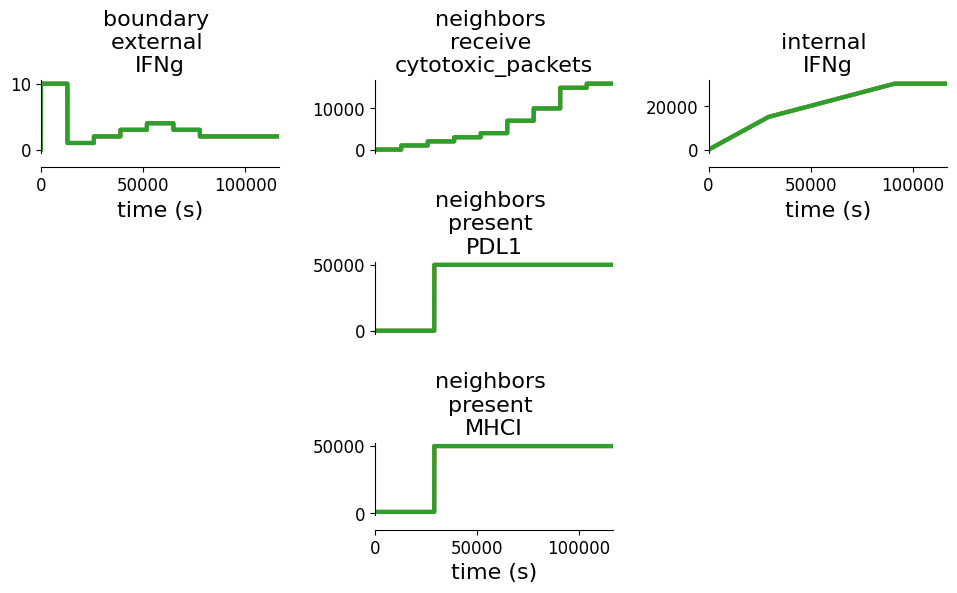

In [3]:
timeline = get_timeline_tumor()
test_batch_tumor(
#     total_time=10000,
    batch_size=3,
    timeline=timeline,
    out_dir=outdir)

The experiment ID is recorded for each experiment and parameters that are set to emit from the process are plotted. We can see that the cell is receiving increasing numbers of cytotoxic packets, it is sensing the IFNg, and made a change in phenotype once it has past the threshold for IFNg. 

### Tcell

The T cell process is focused on two states of a T cell: PD1- with increased secretion of immune molecules (IFNg and cytotoxic packets) and PD1+ with decreased secretion of immune molecules (IFNg and cytotoxic packets). These immune molecules have impact of the state and death of tumor cells. Its transition from the PD1- state is dependent on the length of time it is engaged with tumor cells. 

<img src="https://github.com/vivarium-collective/tumor-tcell/blob/master/jupyter_notebooks/images/1_Tcell_process.png?raw=1" style="height:300px">

In this next cell, we use the function to test out an individual t cell process. 
* This uses a get_timeline_tcell function which feeds input to the t cell process we will plan on exposing it to when we combine it with the environment and other proceses.
* We can change variables like total_time (total simulation time in seconds), batch size (number of simulations to run for the process), timeline (preset inputs), and out_dir (save path for the plots) within the function test_batch_t_cell()


Simulation ID: 83d75b56-6b60-11ee-aa79-064a537592ba
Created: 10/15/2023 at 09:41:16
Completed in 0.162798 seconds

Simulation ID: 83f06fb0-6b60-11ee-aa79-064a537592ba
Created: 10/15/2023 at 09:41:16
Completed in 0.168538 seconds

Simulation ID: 840a630c-6b60-11ee-aa79-064a537592ba
Created: 10/15/2023 at 09:41:17
Completed in 0.201446 seconds


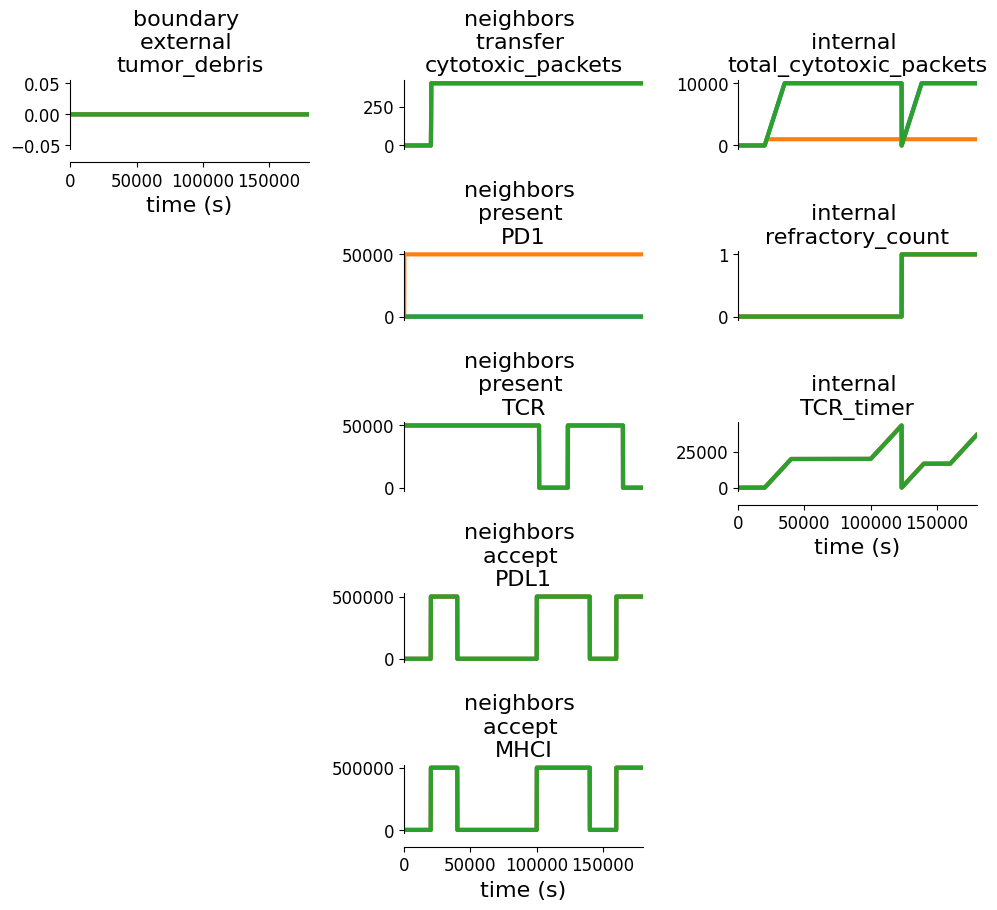

In [4]:
timeline = get_timeline_tcell()
test_batch_t_cell(
    batch_size=3,
    #total_time=100000,
    timeline=timeline,
    out_dir=outdir,
)

The experiment ID is recorded for each experiment and parameters that are set to emit from the process are plotted. We can see that the cell is secreting increasing numbers of cytotoxic packets, some express PD1 depending on phenotype, it downregulates TCR in response to being exposed to MHCI for extended times, and tracks the number of refractory counts (influences cell state transition).

## Composites

Composites are integrated models with multiple initialized processes, and whose inter-connections are specified by a topology. The T-cell and Tumor *processes* shown individually above are here combined with additional processes to create T-cell and Tumor *agents*. These include a division process, which waits for the division flag and then carries out division; a death process, which waits for a death flag and then removes the agent; and a local field, which interfaces the external environment to support uptake and secretion for each individual agent.

### T cell agent



<img src="https://github.com/vivarium-collective/tumor-tcell/blob/master/jupyter_notebooks/images/3_Tcell_compartment.png?raw=1" style="height:300px">

We present how individual processes are connected visually using the plot_topology function below:

#### plot tcell agent topology

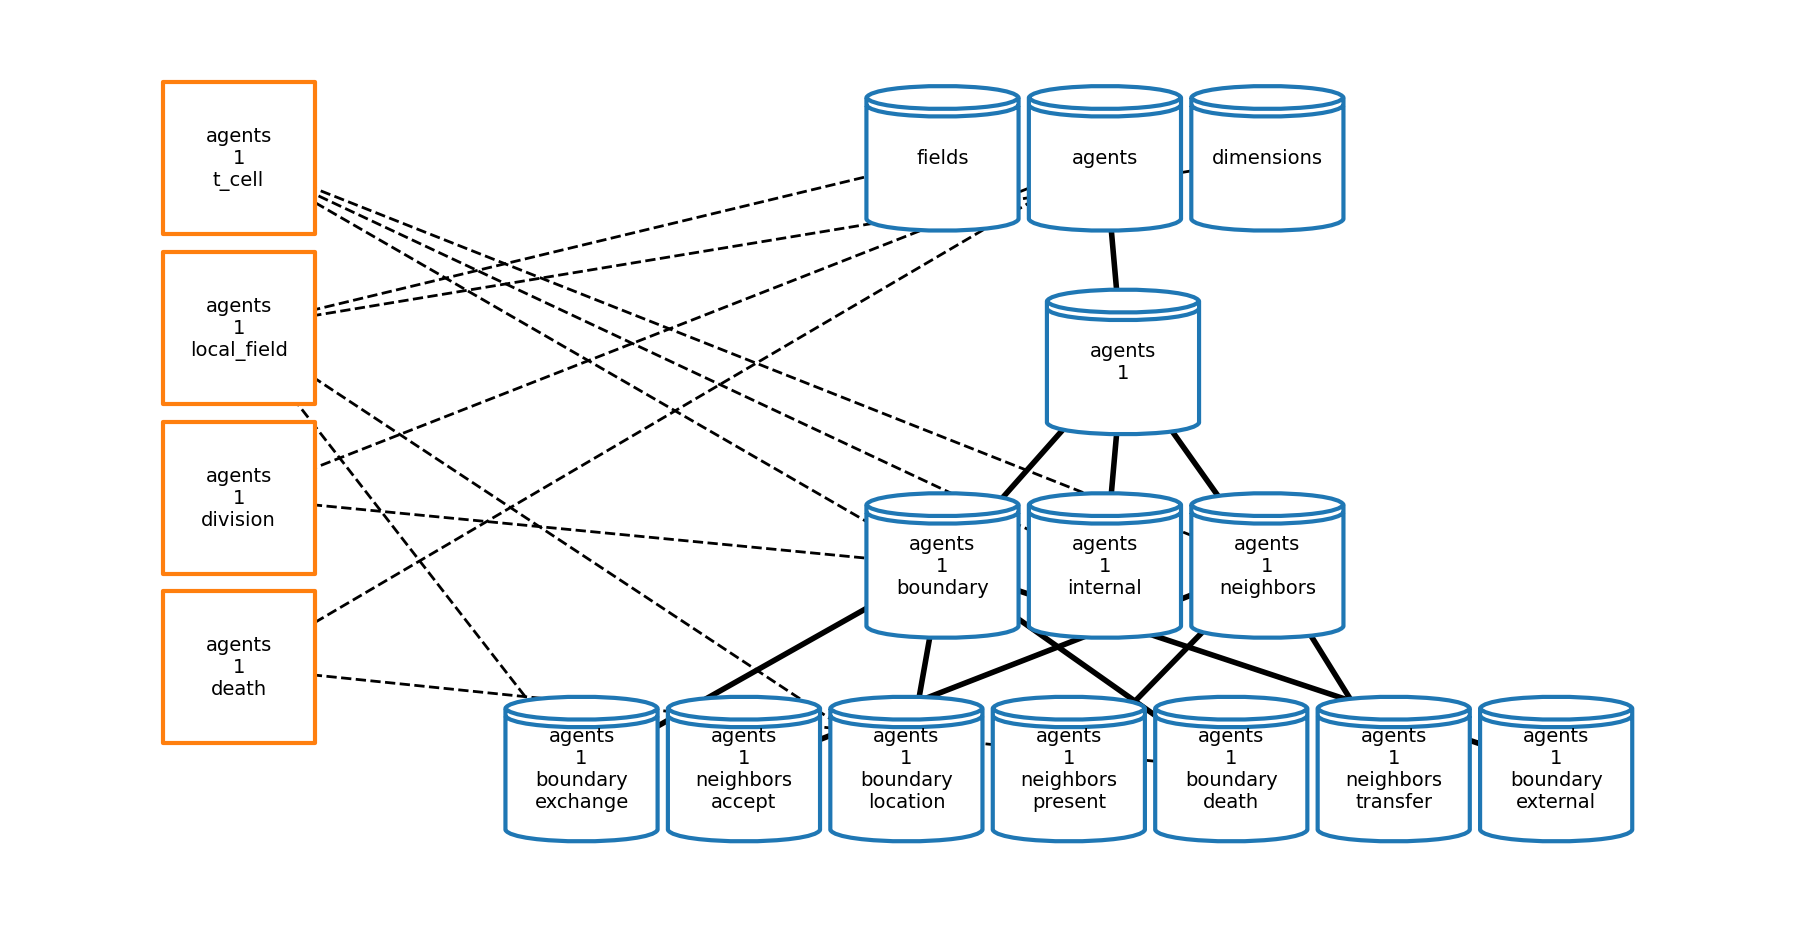

In [5]:
agent_id = '1'
tcell_agent = TCellAgent({'agent_id': agent_id})
agent = tcell_agent.generate(path=('agents', agent_id))
tcell_agent_config = {
    'graph_format': 'hierarchy',
    'dashed_edges': True,
    'show_ports': False,
    'node_size': 12000,
}
fig = plot_topology(agent, tcell_agent_config)

In this next cell, we use the function to test out an individual T cell agent. 
* This uses an agent_timeline which feeds input to the T cell agent we will plan on exposing it to when we combine it with the environment and other proceses.
* We can change variables like total_time (total simulation time in seconds), agent_ids (number of agents to simulate), agent_timeline (preset inputs)

In [6]:
agent_ids = ['0', '1', '2']
agent_timeline = [
    (500, {
        ('neighbors', 'accept', 'PDL1'): 5e5,
        ('neighbors', 'accept', 'MHCI'): 5e5,
    })]
tcell_agent_data = test_tcell_agent(        
    total_time=100000,
    agent_ids=agent_ids,
    agent_timeline=agent_timeline)


Simulation ID: 84ba6900-6b60-11ee-aa79-064a537592ba
Created: 10/15/2023 at 09:41:18
Completed in 1.19 seconds


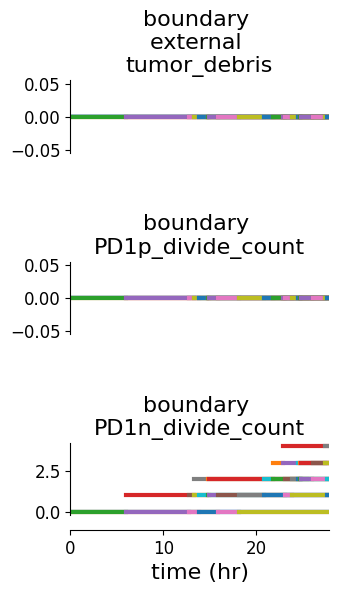

In [7]:
plot_settings = {
        'time_display': '(hr)'
    }
fig = plot_agents_multigen(tcell_agent_data, plot_settings, out_dir=outdir)

The experiment ID is recorded for each experiment and the number of divisions for each cell type are plotted. Each color represents a new cell, and cells that start after time=0 are daughter cells of mother cells that have undergone division. Cells with lines that stop before the end of the timeline have died and have been removed.

### Tumor agent
<img src="https://github.com/vivarium-collective/tumor-tcell/blob/master/jupyter_notebooks/images/4_Tumor_compartment.png?raw=1" style="height:300px">

We present how individual processes are connected visually using the plot_topology function below:

#### plot tumor agent topology

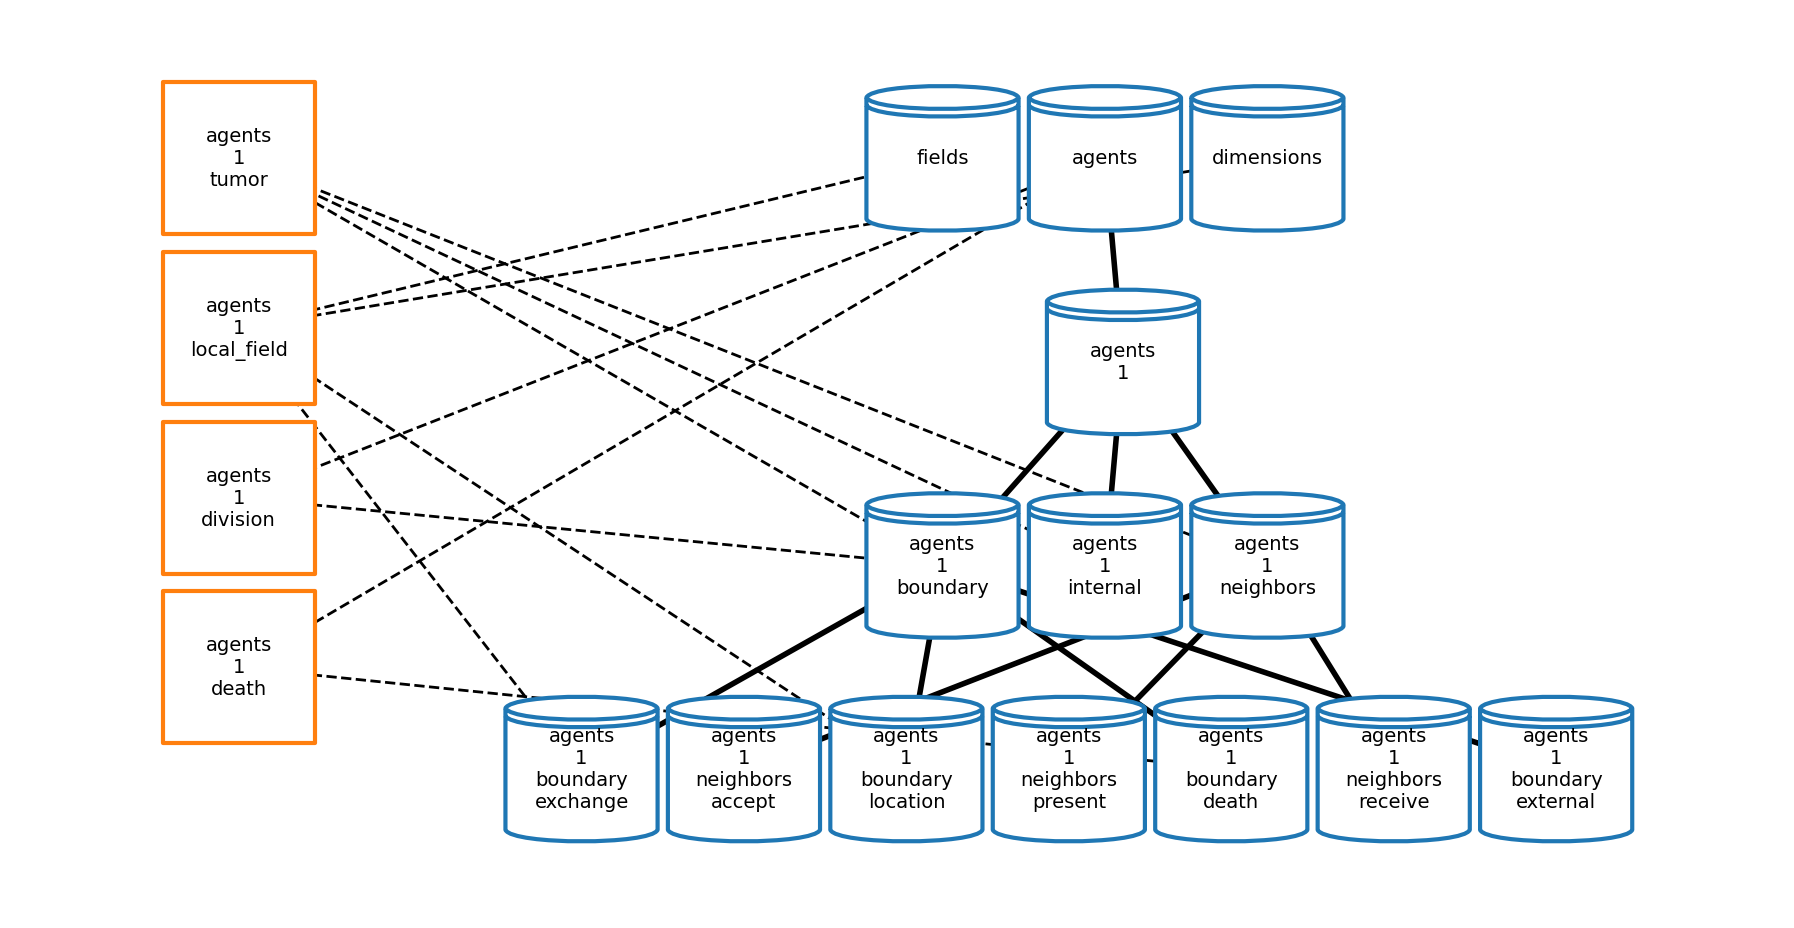

In [8]:
agent_id = '1'
tumor_agent = TumorAgent({'agent_id': agent_id})
agent = tumor_agent.generate(path=('agents', agent_id))
tumor_agent_config = {
    'graph_format': 'hierarchy',
    'dashed_edges': True,
    'show_ports': False,
    'node_size': 12000,
}
fig = plot_topology(agent, tumor_agent_config)

In this next cell, we use the function to test out an individual Tumor cell agent. 
* We can change variables like total_time (total simulation time in seconds), agent_ids (number of agents to simulate), agent_timeline (preset inputs)

In [9]:
agent_ids = ['0', '1', '2']
agent_timeline = []
tumor_agent_data = test_tumor_agent(        
    total_time=100000,
    agent_ids=agent_ids,
#     agent_timeline=agent_timeline
)


Simulation ID: 85c1bc72-6b60-11ee-aa79-064a537592ba
Created: 10/15/2023 at 09:41:20
Completed in 1.03 seconds


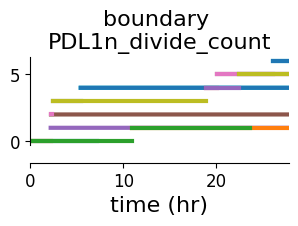

In [10]:
plot_settings = {
        'time_display': '(hr)'
    }
fig = plot_agents_multigen(tumor_agent_data, plot_settings, out_dir=outdir)

The experiment ID is recorded for each experiment and the number of divisions for each cell type are plotted. Each color represents a new cell, and cells that start after time=0 are daughter cells of mother cells that have undergone division. Cells with lines that stop before the end of the timeline have died and have been removed.

### Tumor Microenvironment

`TumorMicroEnvironment` is a composite model that simulates a 2D environment with agents that can move around in space, exchange molecules with their neighbors, and exchange molecules with a molecular field. This composite includes a `neighbors` process, which tracks the locations of individual agents and handles their exchanges, and a `diffusion` process, which operates on the molecular fields. We present how individual processes are connected visually using the plot_topology function below:

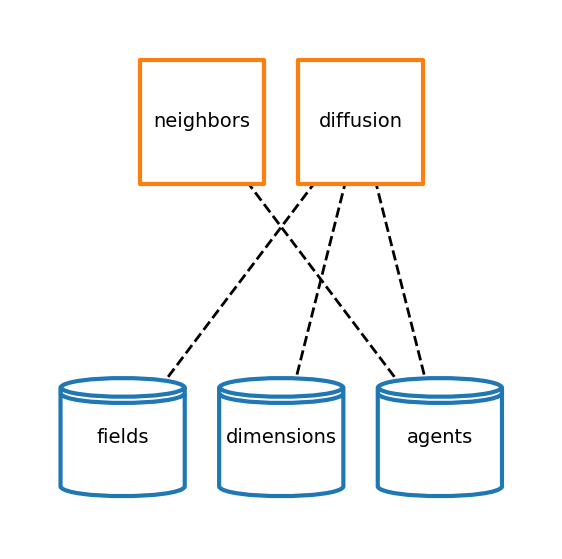

In [11]:
environment = TumorMicroEnvironment()
env_topo_config = {
    'dashed_edges': True,
    'show_ports': False,
    'node_labels':{
        'neighbors_multibody':"neighbors",
        'diffusion_field':"diffusion",
    }}
fig = plot_topology(environment, env_topo_config)

In this next cell, we use the function to test out the environment. This requires specifying:
* bounds (dimensions of the enviornment)
* n_bins (number of bins that the environment will be divided into)
* jitter_force (relative force on immobile bodies
* largely unimportant for the scale of mammalian cells)
* diffusion (diffusion coefficient)
* n_agents (number of agents for the simulation
* end_time (total time of simulation)


Simulation ID: 867b6a32-6b60-11ee-aa79-064a537592ba
Created: 10/15/2023 at 09:41:21
Completed in 0.003139 seconds


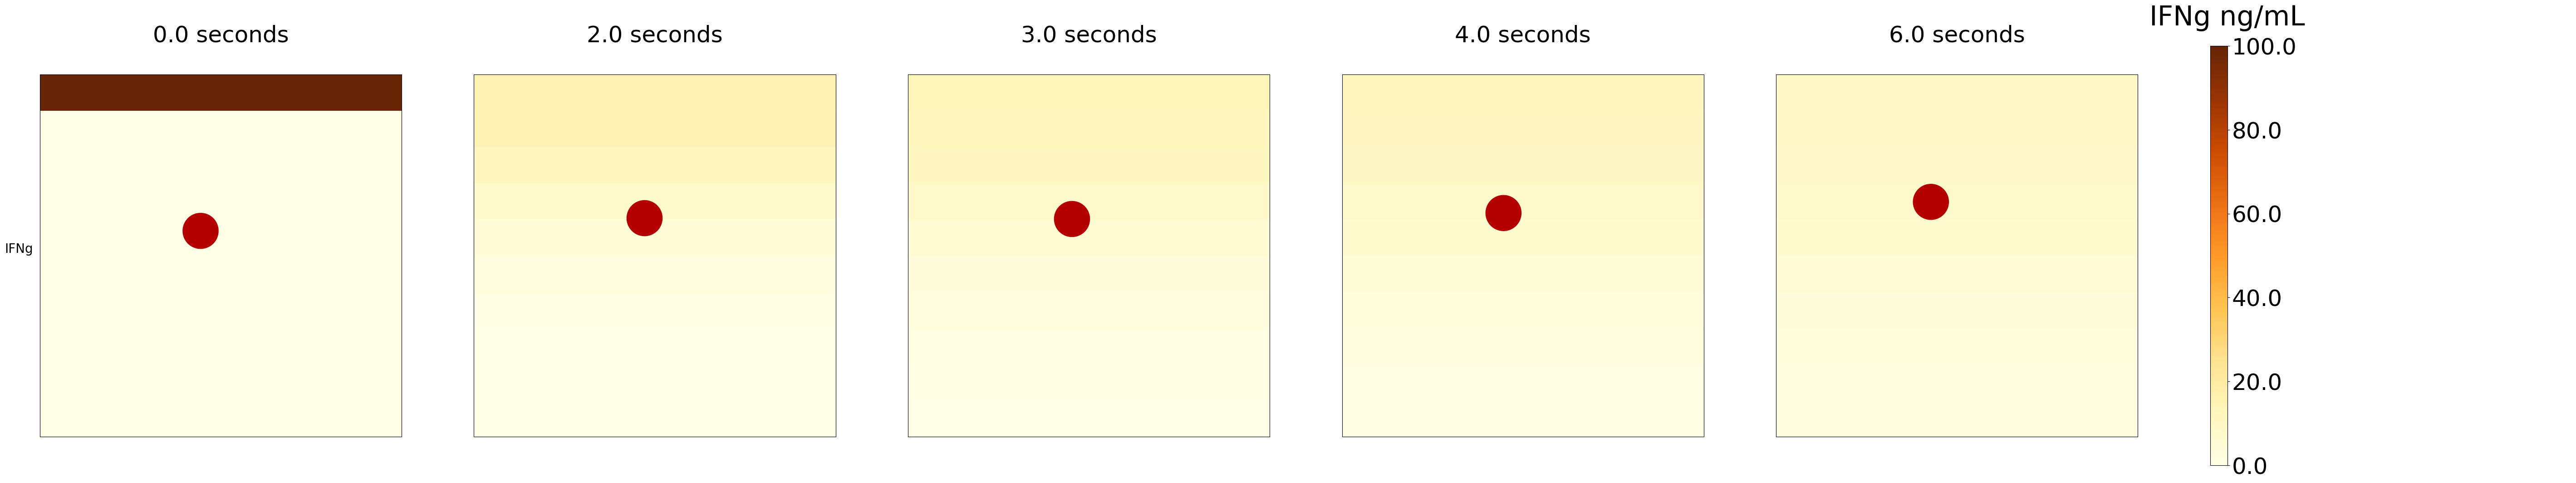

In [12]:
bounds=[10 * units.um, 10 * units.um]

data = test_microenvironment(
    bounds=bounds,
    n_bins=[10, 10],
    jitter_force=1e-4,
    diffusion=1e-9,
    n_agents=1,
    end_time=6)

# snapshot plot
agents, fields = format_snapshot_data(data)
fig = plot_snapshots(
    agents=remove_units(agents),
    fields=fields,
    bounds=remove_units(bounds),
    n_snapshots=5,
    time_display='seconds',
    out_dir=outdir,
    filename='snapshots')

The experiment ID is recorded for each experiment. We can see that only 1 agent is loaded into the enviornment with IFNg defined at a high local concentration that slowly diffuses over the bin space throughout the experiment.  

## Experiments

Now that we have validated all individual processes are behaving as we would expect, we can connect all together and provide additional behaviors like migration to individual elements. 

In our Multi-scale agent based model, the T cells can interact with tumor cells in the following ways:
* T cell receptor (TCR on T cells) and Major histocompatibility complex I receptor (MHCI on tumor cells) for activation of T cells, induction of IFNg and cytotoxic packet secretion, and slowing of T cell migration
* PD1 receptor (on T cells) and PDL1 receptor (on tumor cells) that can inhibit cell activation and induce apoptosis
* T cells secrete IFNg which tumor cells uptake and causes state switch to upregulate MHCI, PDL1, and decrease proliferation

<img src="https://github.com/vivarium-collective/tumor-tcell/blob/master/jupyter_notebooks/images/5_ABM.png?raw=1" style="height:300px">

In this next cell, we use the function to test out an experiment that allows us to change variables such as:

* tumors: initial tumors fed into the simulation. In this case we feed in DEFAULT_TUMORS that can be created by inputting total number (N_TUMORS) and percentage (PDL1n_per) into get_tumors.
* tcells: initial tumors fed into the simulation. In this case we feed in DEFAULT_TCELLS that can be created by inputting total number (N_TCELLS) and percentage (PD1n_per) into get_tumors.
* TIMESTEP: duration of each simulation interval in seconds
* bounds: dimension of the environment (in this case BOUNDS)
* total_time: total simulation time in seconds
* halt_threshold: if the number of total cells becomes greater than this amount it will prematurely stop the simulation at this timestep
* emit_step: how often the data is emitted from an experiment
* sim_step: how often the halt_threshold is checked

In [13]:
##With simulated data
N_TUMORS = 120
N_TCELLS = 12
relative_pd1n = 0.5
relative_pdl1n = 0.5
DEFAULT_TUMORS = get_tumors(number=N_TUMORS, relative_pdl1n=relative_pdl1n)
DEFAULT_TCELLS = get_tcells(number=N_TCELLS, relative_pd1n=relative_pd1n)

# global parameters
TIMESTEP = 60
BOUNDS = [200 * units.um, 200 * units.um]

data = tumor_tcell_abm(total_time=10800, tumors=DEFAULT_TUMORS, tcells=DEFAULT_TCELLS, 
                       halt_threshold=500,emit_step=60, bounds=BOUNDS,sim_step=10*TIMESTEP,)
data = remove_units(data)
data;

Initializing experiment tumor_tcell_20231015.094122


100%|███████████████████████████████████████████| 18/18 [00:13<00:00,  1.38it/s]


Completed in 13.04 seconds


## Analysis

With the saved `data` we can now use it to look both at outputs from the simulation at both a single-cell and population level stage.

### Single Cell

For single cell analysis, plots and analysis can be directly used from `plots_suite`

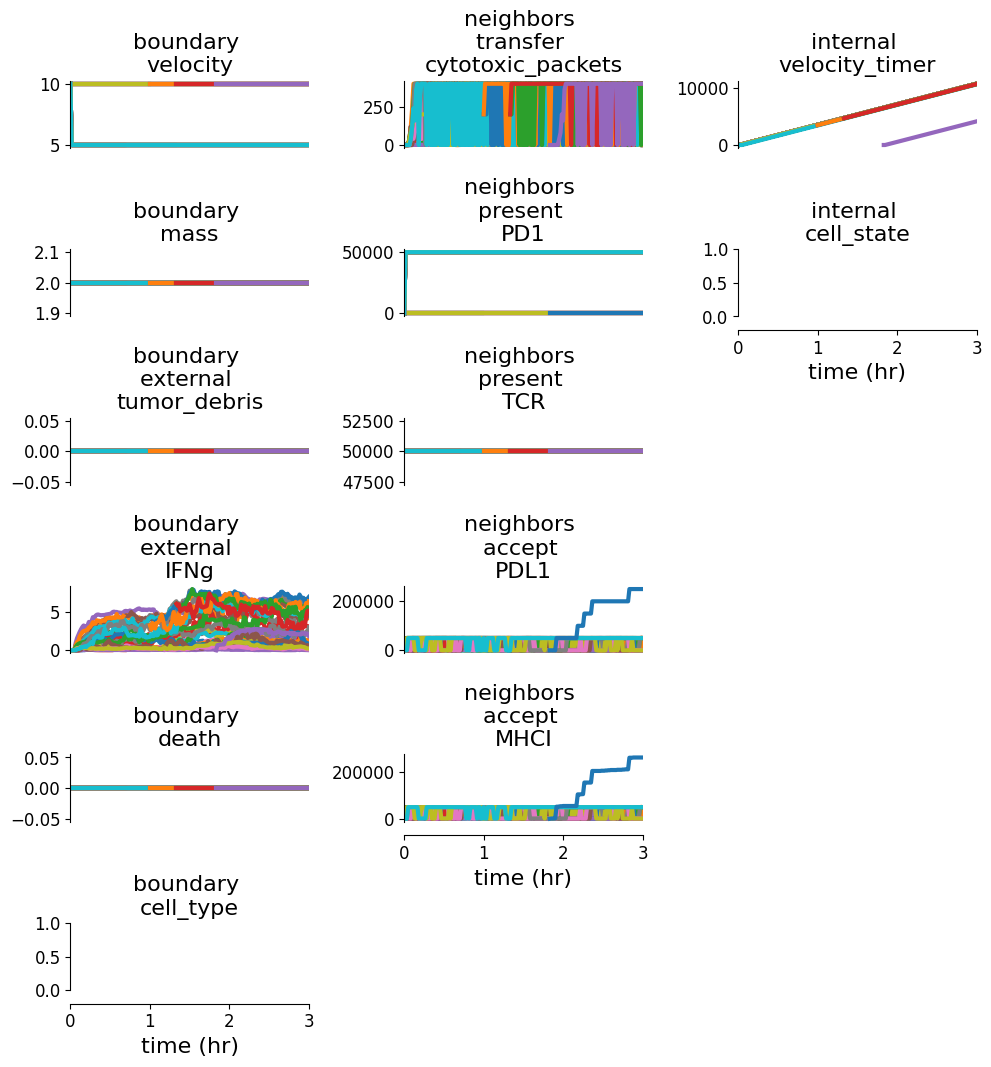

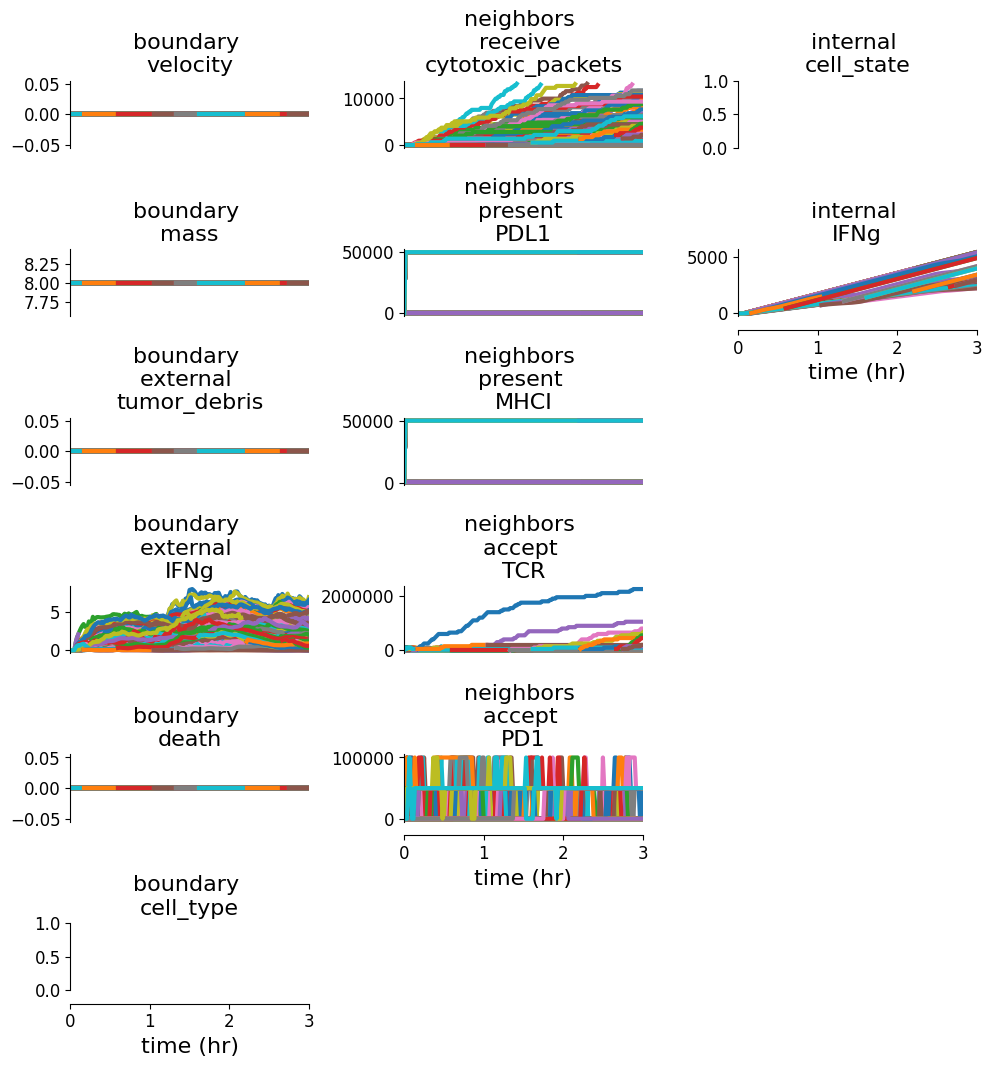

<Figure size 400x200 with 0 Axes>

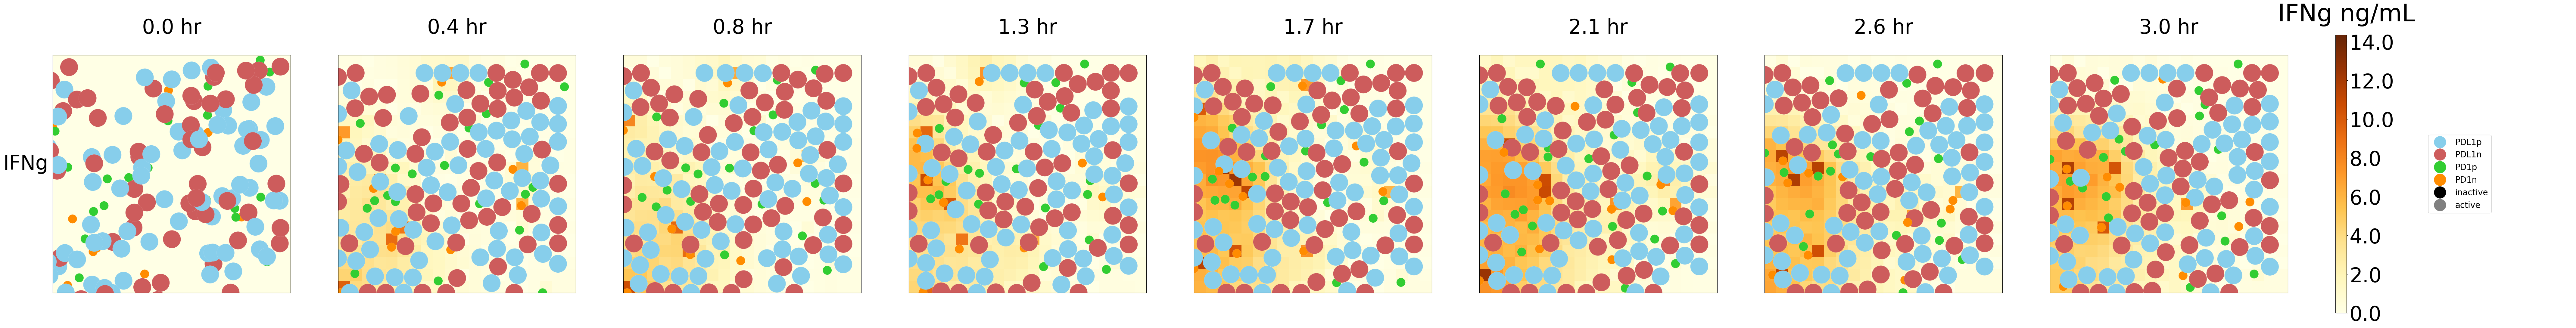

In [17]:
#Plot the data using tumor-tcell experiment notebook and save in current directory
fig1, fig2, fig3, _ = plots_suite(data, out_dir=outdir, bounds=[b*units.um for b in BOUNDS])

We can see a number of important single-cell behavior from this small-scale experiment that is completed within about 3 minutes. 

For T cell single cell plots:
* Cells enter refractory periods as can be seen from down-regulation of TCR
* Cells are migrating and stopping at tumor cell interfaces when contacting tumor cells
* Cells are transfering cytotoxic packets to tumor cells

For Tumor cell single cell plots:
* Cells enter refractory periods as can be seen from down-regulation of TCR
* Cells are interacting with numerouse T cells as indicated by accepting number of TCR receptors increases
* Cells are receiving cytotoxic packets from T cells in close proximity

For the snapshot environment plots:
* T cells are migratory whereas tumor cells are relatively motionless
* IFNg increases as T cells continue to secrete into the environment and tumor uptake decreases with decreasing tumor cells
* Tumor cells change state to PDL1+ tumor cells after extended presence of IFNg
* T cells are proliferating and killing tumor cells

### Population Dynamics

For population statistics and visual output we reformat the data from nested dictionaries to pandas dataframes using a variety of functions from tumor_tcell. 

In [18]:
df_tumor_death, df_tcell_death, tumor_plot, tcell_plot = data_to_dataframes(data)

In [19]:
divide_time_T = division_analysis(tcell_plot)

In [20]:
divide_time_tumor = division_analysis(tumor_plot)

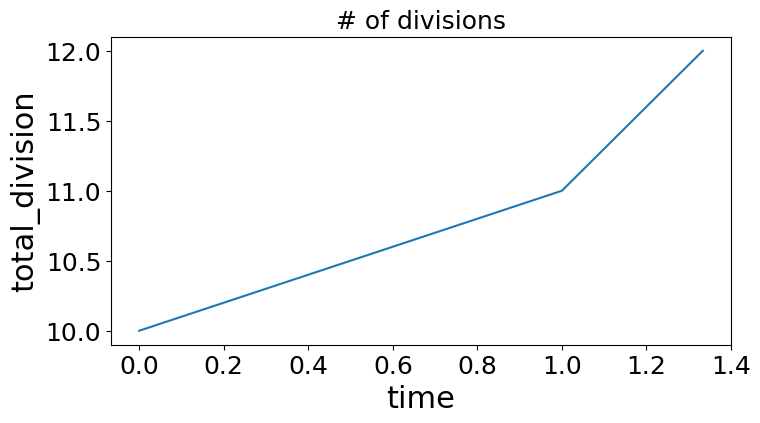

In [21]:
division_plot(divide_data = divide_time_T, out_dir = outdir, save_name='Tcells')

This plot shows the cumulative number of divisions amongst the T cells within the simulation

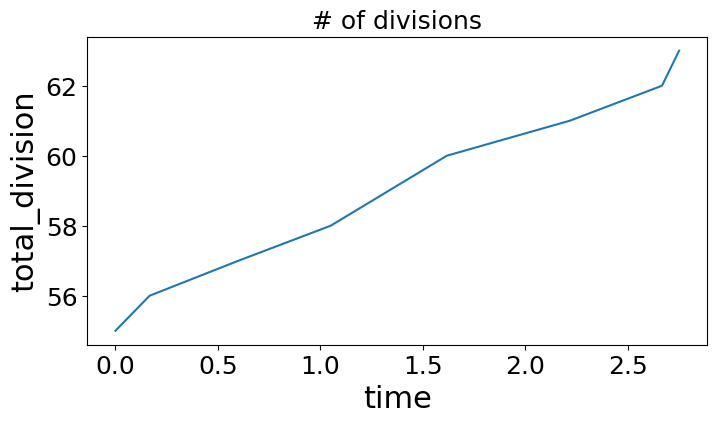

In [22]:
division_plot(divide_data = divide_time_tumor, out_dir = outdir, save_name='Tumors')

This plot shows the cumulative number of divisions amongst the Tumor cells within the simulation

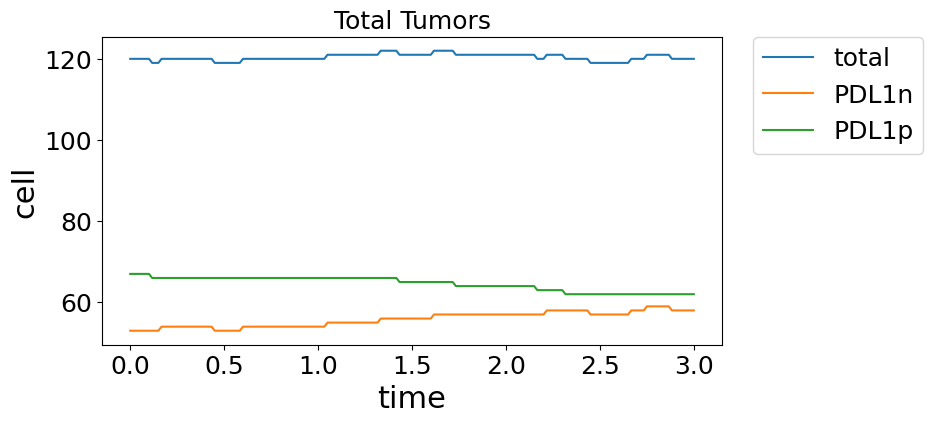

In [23]:
population_plot(population_data = tumor_plot, cell_states = ['PDL1n','PDL1p'], out_dir=outdir, save_name='Tumors')

This plot shows how the total number (blue) and PDL1n (orange) and PDL1p (green) of Tumors changes over time

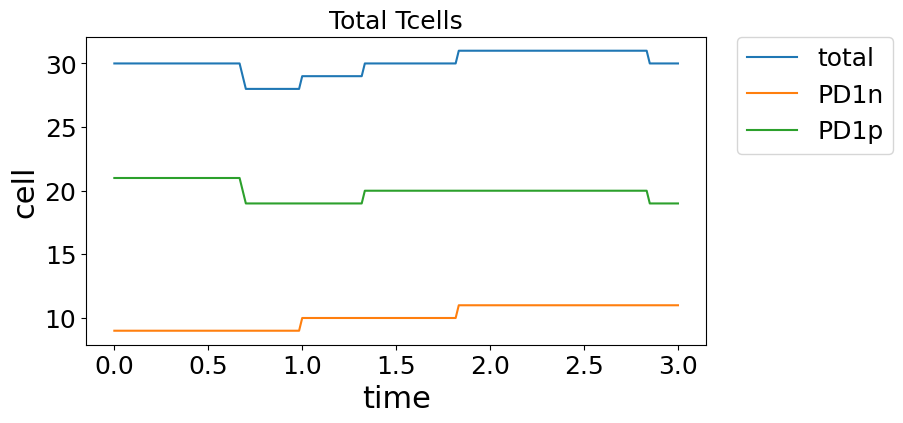

In [24]:
population_plot(population_data = tcell_plot, cell_states = ['PD1n','PD1p'], out_dir=outdir, save_name='Tcells')

This plot shows how the total number (blue) and PD1n (orange) and PD1p (green) of T cells changes over time

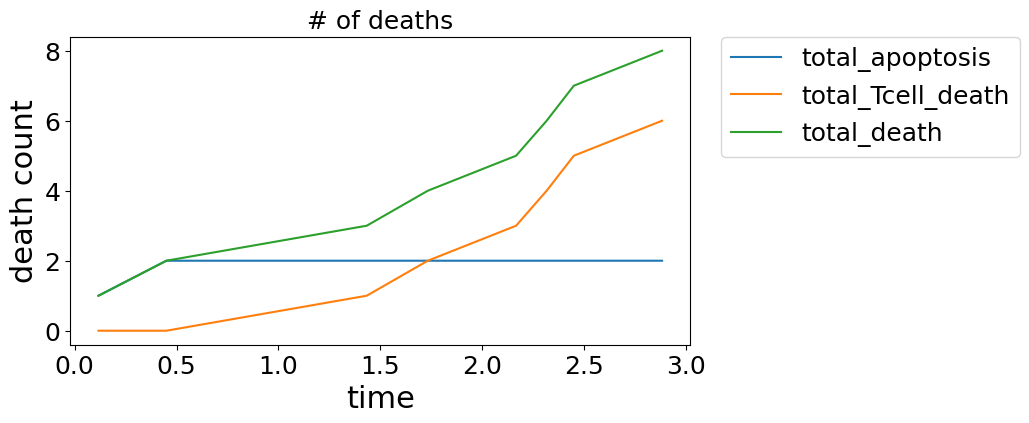

In [25]:
death_plot(death_data = df_tumor_death, out_dir=outdir, save_name='Tumors')

This plot shows how the total death count, T cell induced death, and apoptosis of Tumors changes over time

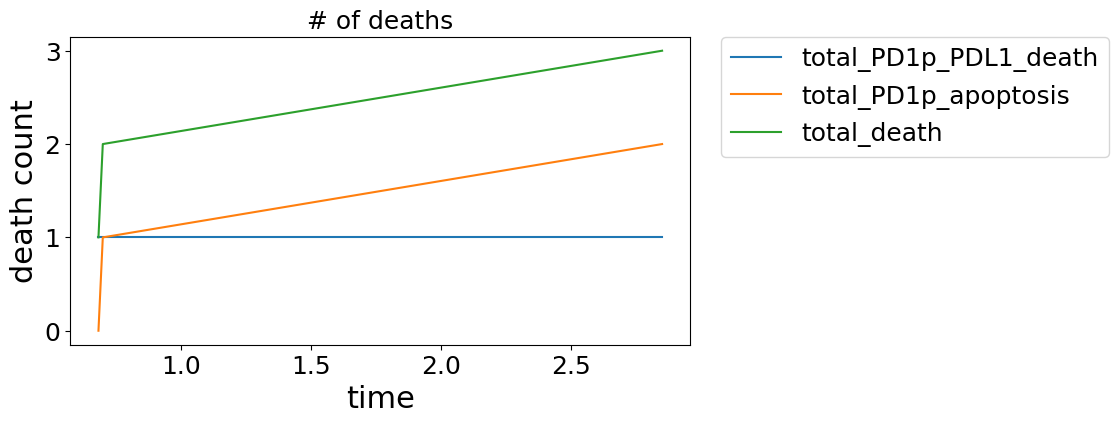

In [26]:
death_plot(death_data = df_tcell_death, out_dir=outdir, save_name='Tcells')

This plot shows how the total death count, PDL1 induced death, and apoptosis of T cells changes over time